In [1]:
import numpy as np
import keras
from keras.applications import VGG16
from keras import models, layers, optimizers
from keras.models import load_model, Model
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from keras.layers import Dense

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import imgaug as ia
from imgaug import augmenters as iaa
import random
import numpy as np

import boto3

from random import randint
import math
import datetime
import scipy.io
import cv2
import os

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Setup Constants

In [2]:
HANDS_DATASET = '../data/original/hand_dataset'

DATA_DIR = '../data'

IMAGE_TEST_DIR = os.path.join(HANDS_DATASET, 'test_dataset/test_data')
IMAGE_VALIDATION_DIR = os.path.join(HANDS_DATASET, 'validation_dataset/validation_data')
IMAGE_TRAIN_DIR = os.path.join(HANDS_DATASET, 'training_dataset/training_data')
SAVED_MODEL_DIR = os.path.join(DATA_DIR, 'models/hands_localization')

IMAGE_SHAPE=(150, 150, 3)
MAX_HANDS_TO_DETECT = 10
FLATTENED_DIMENSIONS = MAX_HANDS_TO_DETECT * 4 * 2
#LIMIT_DATA = 40
LIMIT_DATA = -1

NUM_EPOCHS = 20
BATCH_SIZE = 20

# PRETRAIN_MODEL = 'conv_base_local'
PRETRAIN_MODEL = None

### Load in pretrained models

In [3]:
conv_base_local = load_model('../data/models/2018-10-09 20:54:49___0.940677957009461.h5')

In [4]:
conv_base_local.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 12, 128)       147584    
__________

In [5]:
conv_base_vgg16 = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
conv_base_vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

### Load annotations from a specified file

In [6]:
def load_annotations(file):
    f = scipy.io.loadmat(file)
    data = f.get('boxes')
    data = np.array(data)
    
    # We only want the rectangular points from each annotation
    image_annotations = []
    for hand in data[0]:
        # I'm not entirely sure why, but the shape of each file seems to be wrapped in a lot of empty lists
        polygon_points = hand[0][0]
        # We only want the first four items (that actually make up the polygon)
        polygon_points = list(polygon_points)[:4]
        # Again, each point has an empty list wrapped around
        polygon_points = [point[0] for point in polygon_points]
        # points are actually reversed, we want them to be [x, y], but matlab really likes them as [y, x]
        image_annotations.append([[point[1], point[0]] for point in polygon_points])
        

    return image_annotations

len(load_annotations('/Users/kjprice/Library/Projects/smu/capstone/data/original/hand_dataset/validation_dataset/validation_data/annotations/Movie_4weds_1.mat'))


5

### Pull images/annotations from directory

In [7]:
def load_annotations_from_dir(directory):
    annotations_dir = os.path.join(directory, 'annotations')
    annotation_files = os.listdir(annotations_dir)
    annotations_for_all_files = []
    i = 0
    for annotation_file in annotation_files:
        if LIMIT_DATA > -1 and i == LIMIT_DATA:
            break
        # ignore config files
        if annotation_file.find('.') == 0:
            continue
        matlab_filepath = os.path.join(annotations_dir, annotation_file)
        annotations = load_annotations(matlab_filepath)
        annotations_for_all_files.append(annotations)
        i += 1
    return annotations_for_all_files

def load_images_from_dir(directory):    
    images_dir = os.path.join(directory, 'images')
    images = os.listdir(images_dir)

    imgs = [] # TODO: Delete

    i = 0
    for _file in images:
        if LIMIT_DATA > -1 and i == LIMIT_DATA:
            break
        # ignore config files
        if _file.find('.') == 0:
            continue
        filepath = os.path.join(images_dir, _file)
        img = load_img(filepath, target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        img_ORIGINAL = load_img(filepath)
        #imgs.append(img_ORIGINAL)
        imgs.append(img_to_array(img_ORIGINAL))
        i += 1

        
    return imgs

### Resize images and annotations

In [8]:
# Takes a list of images and their correalted annotations (each image has a matching annotation)
def resize_images_and_annotations(images, annotations):
    if len(images) != len(annotations):
        raise Exception('Length of images {} does not match length of annotations'.format(images, annotations))
        global MAX_HANDS_TO_DETECT, FLATTENED_DIMENSIONS
        
    
    new_images = []
    new_annotations = []
    for (image, annotation) in zip(images, annotations):
        resized_image = cv2.resize(image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        
        original_height, original_width, original_depth = image.shape
        resized_image = cv2.resize(image, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]))
        new_height, new_width, new_depth = resized_image.shape
        width_change = new_width / original_width
        height_change = new_height / original_height

        new_annotation = []
        for hand_count in range(MAX_HANDS_TO_DETECT):
            # we have run out of hands, insert a hand with no points
            if len(annotation) <= hand_count:
                new_annotation.append([[0, 0], [0, 0], [0, 0], [0, 0]])
                continue
            hand = annotation[hand_count]

            new_hand = []
            for point in hand:
                x, y = point
                new_x = x * width_change
                new_y = y * height_change
                new_point = [new_x, new_y]
                new_hand.append(new_point)

            new_annotation.append(new_hand)

        new_annotations.append(new_annotation)
        
        normalized_image = resized_image / 255
        new_images.append(normalized_image)
        flattened_annotations = np.reshape(new_annotations, (len(new_annotations), FLATTENED_DIMENSIONS))
    return (new_images, flattened_annotations)

### Load images and annotations

In [9]:
def load_images_as_np(directory):
    
    input_shape = (IMAGE_SHAPE[2], IMAGE_SHAPE[1], IMAGE_SHAPE[0])

    images_original = load_images_from_dir(directory)
    annotations_original = load_annotations_from_dir(directory)
    
    # Todo: This should be done dynamically using imgaug
    x_dataset, y_dataset = resize_images_and_annotations(images_original, annotations_original)
            
    return x_dataset, y_dataset

In [10]:
%time x_train, y_train = load_images_as_np(IMAGE_TRAIN_DIR)

CPU times: user 3min 52s, sys: 58.4 s, total: 4min 50s
Wall time: 4min 46s


In [11]:
%time x_val, y_val = load_images_as_np(IMAGE_VALIDATION_DIR)

CPU times: user 19.7 s, sys: 1.56 s, total: 21.2 s
Wall time: 21.1 s


In [12]:
%time x_test, y_test = load_images_as_np(IMAGE_TEST_DIR)

CPU times: user 16.6 s, sys: 1.16 s, total: 17.8 s
Wall time: 18.8 s


### Visualize the annotations on the images

In [13]:
# takes a list of flat annotations and will turn them into actual polygon shapes (around hands)
def hands_from_flat_annotation(annotation):
    annotation = np.array(annotation)
    return annotation.reshape(MAX_HANDS_TO_DETECT, 4, 2).tolist()
    
def hands_from_flat_annotations(annotations):
    return [hands_from_flat_annotation(annotation) for annotation in annotations]
np.array(hands_from_flat_annotations(y_train)).shape

(4069, 10, 4, 2)

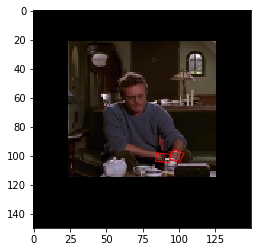

In [14]:
def display_image_with_annotation(img, annotations, ax = plt.gca()):
    plt.imshow(array_to_img(img))
    annotations = hands_from_flat_annotation(annotations)
    for annotation in annotations:
        line = plt.Polygon(annotation, fill=None, edgecolor='r')
        ax.add_patch(line)

first_annotations_from_first_video = y_train[0]
first_image = x_train[0]
display_image_with_annotation(first_image, first_annotations_from_first_video)

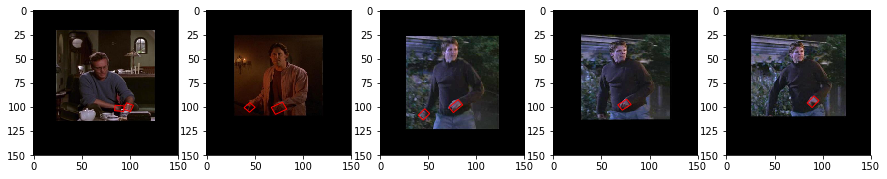

In [15]:
def display_images_with_annotations(imgs, annotations):
    i = 1
    num_rows = 1
    num_cols = len(imgs)
    f = plt.figure(figsize=(15,5))
    for img, annotation in zip(imgs, annotations):
        ax = f.add_subplot(1, num_cols, i)
        display_image_with_annotation(img, annotation, ax)
        i += 1
        

display_images_with_annotations(x_train[:5], y_train[:5])

# Augment Images and Annotations using imgaug

In [16]:
def turn_annotations_into_keypoints(annotations):
    annotations = hands_from_flat_annotations(annotations.copy())
    keypoints_on_images = []
    for hands in annotations:
        keypoints = []
        for hand in hands:
            for point in hand:
                keypoints.append(ia.Keypoint(x=point[0], y=point[1]))
        keypoints_on_images.append(ia.KeypointsOnImage(keypoints, shape=IMAGE_SHAPE))
    return keypoints_on_images

def augment_images_and_keypoints(images, keypoints_on_images):
    image_width = IMAGE_SHAPE[0]
    augmentors = [
        #iaa.GaussianBlur((0, 3.0)),
        iaa.Affine(
            scale=(0.7, 1.3),
            rotate=(-45, 45),
            shear=(-45, 45),
            mode='edge'
        ),
        iaa.Fliplr(.5),
        iaa.Dropout(.1),
        #iaa.Affine(mode='edge'),
        #iaa.CropAndPad(1),
        #iaa.Crop(px=(0, 16)),
    ]
    seq = iaa.Sequential(augmentors)
    seq_det = seq.to_deterministic() # call this for each batch again, NOT only once at the start
    images_aug = seq_det.augment_images(images)
    keypoints_aug = seq_det.augment_keypoints(keypoints_on_images)
    return images_aug, keypoints_aug

def keypoints_into_annotations(keypoints_on_images):
    annotations = []
    for keypoints in keypoints_on_images:
        image_annotation = []
        for keypoint in keypoints.keypoints:
            image_annotation.append(keypoint.x)
            image_annotation.append(keypoint.y)
        annotations.append(image_annotation)
    return annotations
        
    
keypoints = turn_annotations_into_keypoints(y_train)
imgs, pts = augment_images_and_keypoints(x_train, keypoints)
print(np.array(imgs[0]).shape)
print(y_train[0][0:2])
print(pts[0].keypoints[0])
keypoints_into_annotations(keypoints)[0][0:2]

(150, 150, 3)
[ 83.88898309 103.62720285]
Keypoint(x=67.89818709, y=111.48808277)


[83.88898308635177, 103.6272028475069]

### Create Generator that will augment data

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
generator using 821 features
CPU times: user 205 ms, sys: 75.3 ms, total: 280 ms
Wall time: 285 ms
CPU times: user 59.3 ms, sys: 1.11 ms, total: 60.4 ms
Wall time: 59.7 ms
CPU times: user 30.7 ms, sys: 1.05 ms, total: 31.7 ms
Wall time: 32.3 ms
CPU times: user 59.4 ms, sys: 1.35 ms, total: 60.8 ms
Wall time: 60.1 ms
CPU times: user 29.5 ms, sys: 445 µs, total: 29.9 ms
Wall time: 29.6 ms
CPU times: user 59.8 ms, sys: 1.7 ms, total: 61.5 ms
Wall time: 60.2 ms


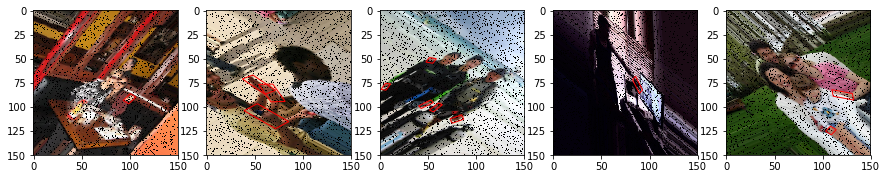

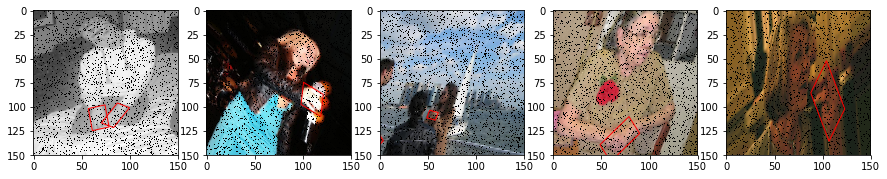

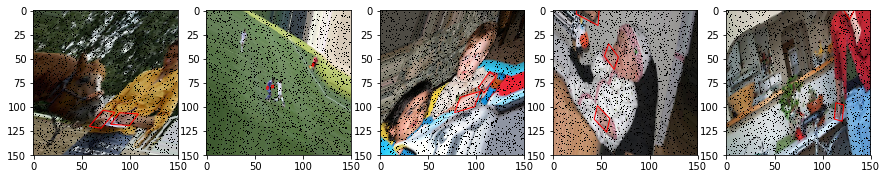

In [17]:
def augmentation_generator(features, labels, batch_size):
    feature_size = len(features)
    print('generator using {} features'.format(feature_size))
    return_features = features.copy()
    return_labels = turn_annotations_into_keypoints(labels)

    # create empty arrays to contains batch of features and labels
    batch_features = np.zeros((batch_size, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))
    batch_labels = np.zeros((batch_size, FLATTENED_DIMENSIONS))	# X and Y coordinates
    
    batches_completed = 0
    
    # randomize the indexes to access features
    # for each batch, increment batches_completed
    # if batches_completed % feature_size == 0, then create a new set of randomized indexes

    while True:
        randomized_indices = np.random.choice(feature_size, feature_size, replace=False)
        
        for i in range(batch_size):
            index = randomized_indices[i]
            

            random_augmented_image, random_augmented_labels = augment_images_and_keypoints([return_features[index]], [return_labels[index]])
            batch_features[i] = random_augmented_image[0]
            batch_labels[i] = keypoints_into_annotations(random_augmented_labels)[0]

        yield batch_features, batch_labels

        
%time __gen__ = augmentation_generator(x_test, y_test, 10)
%time imgs, labels = next(__gen__)
%time display_images_with_annotations(imgs[:5], labels[:5])
%time imgs, labels = next(__gen__)
%time display_images_with_annotations(imgs[:5], labels[:5])
%time imgs, labels = next(__gen__)
%time display_images_with_annotations(imgs[:5], labels[:5])



### Create Model

In [18]:
# Create new model
conv_base = None

if PRETRAIN_MODEL == 'conv_base_local':
    conv_base = conv_base_local

    # Get input
    new_input = conv_base.input
    # Find the layer to connect
    hidden_layer = conv_base.layers[-4].output
    # Build a new model
    conv_base = Model(new_input, hidden_layer)
if PRETRAIN_MODEL == 'conv_base_vgg16':
    conv_base = conv_base_vgg16

if conv_base is not None:
    conv_base.summary()

In [19]:
model = None

def create_model_from_base():
    model = models.Sequential()
    model.add(conv_base)

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(FLATTENED_DIMENSIONS)) # linear
    model.compile(optimizer=optimizers.RMSprop(lr=.001), loss='mse', metrics=['mae'])
    return model


def create_model_from_scratch():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=[IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]]))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(FLATTENED_DIMENSIONS)) # linear
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

if PRETRAIN_MODEL == 'conv_base_local' or PRETRAIN_MODEL == 'conv_base_vgg16':
    model = create_model_from_base()
else:
    model = create_model_from_scratch()

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

### Create plot to show MAE and Loss

In [21]:
def plot_mae(history):
    plt.figure()
    mae = history.history['mean_absolute_error']
    val_mae = history.history['val_mean_absolute_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(mae))

    plt.plot(epochs, mae, 'bo', label='Training mae')
    plt.plot(epochs, val_mae, 'b', label='Validation mae')
    plt.title('Training and validation mae')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation Loss')
    plt.legend()

    plt.show()

### Create checkpoints

In [22]:
def callback(x, y):
    y_predictions = model.predict([x_test[:5]])
    display_images_with_annotations(x_test[:5], y_predictions[:5])

lambda_callback = keras.callbacks.LambdaCallback(on_epoch_end=callback)


## Train model

generator using 4069 features
Epoch 1/20
204/203 [==============================] - 114s 558ms/step - loss: 5126.1756 - mean_absolute_error: 50.5906 - val_loss: 1403.6128 - val_mean_absolute_error: 31.2180
Epoch 2/20
204/203 [==============================] - 112s 548ms/step - loss: 3675.6783 - mean_absolute_error: 47.3059 - val_loss: 1741.3075 - val_mean_absolute_error: 35.9181
Epoch 3/20
204/203 [==============================] - 110s 539ms/step - loss: 3534.1881 - mean_absolute_error: 46.7080 - val_loss: 3856.9260 - val_mean_absolute_error: 53.0987
Epoch 4/20
204/203 [==============================] - 110s 538ms/step - loss: 3446.0724 - mean_absolute_error: 45.9548 - val_loss: 3105.3861 - val_mean_absolute_error: 45.5954
Epoch 5/20
204/203 [==============================] - 110s 540ms/step - loss: 3436.8264 - mean_absolute_error: 45.9098 - val_loss: 2156.8488 - val_mean_absolute_error: 40.0587
Epoch 6/20
204/203 [==============================] - 114s 560ms/step - loss: 3469.6150 - 

/usr/local/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


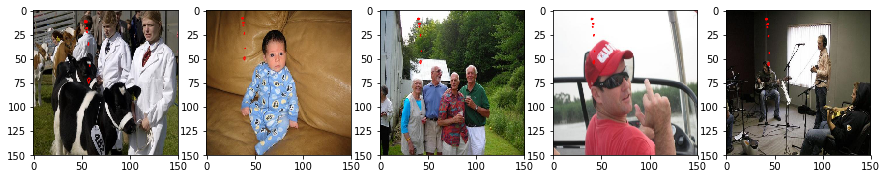

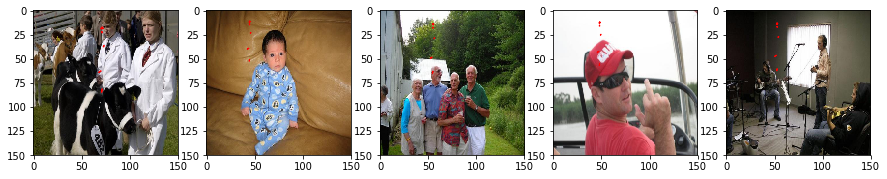

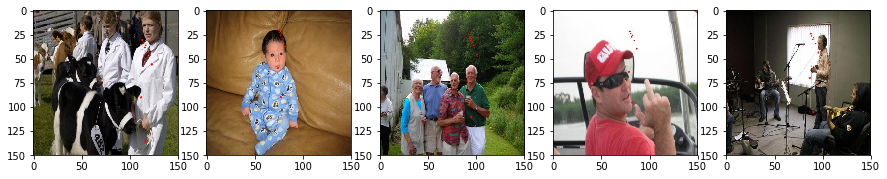

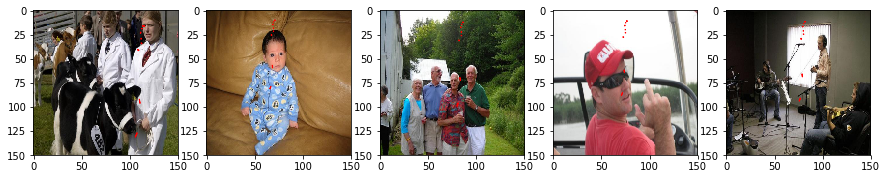

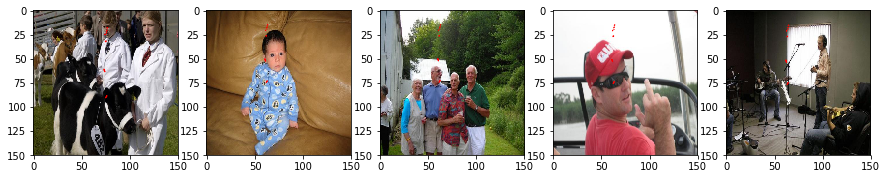

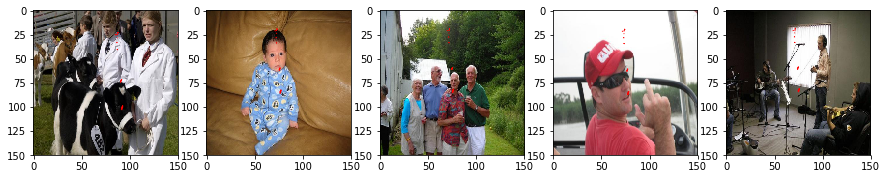

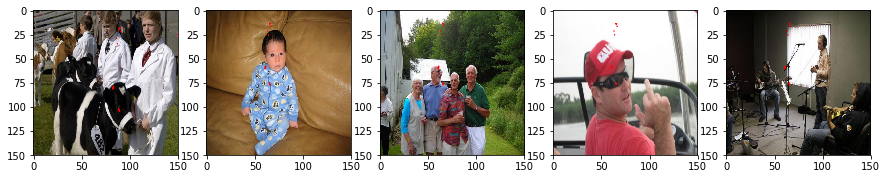

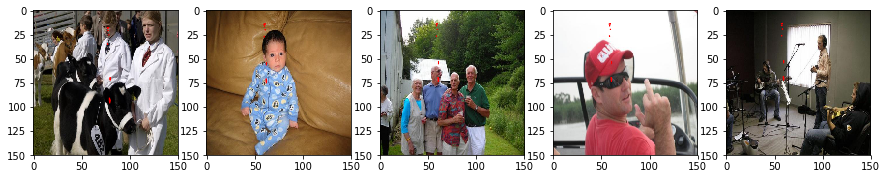

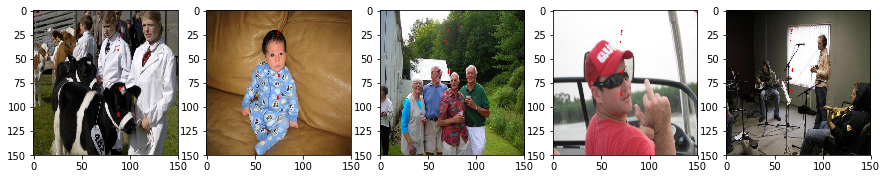

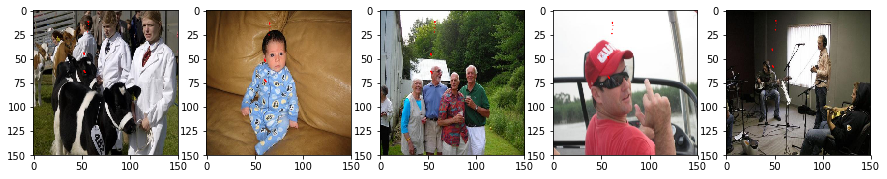

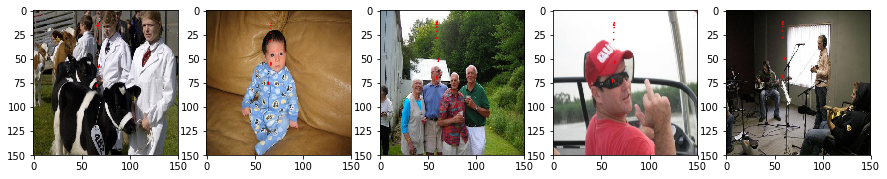

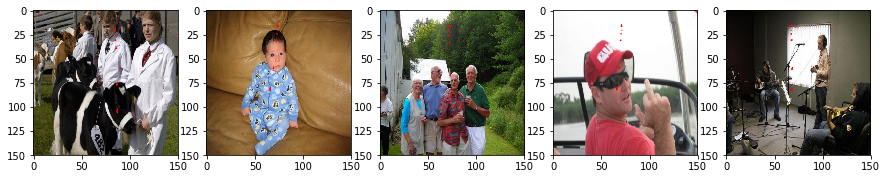

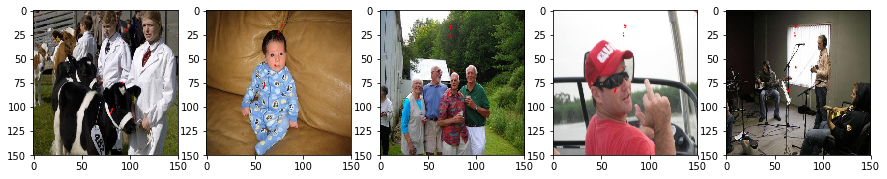

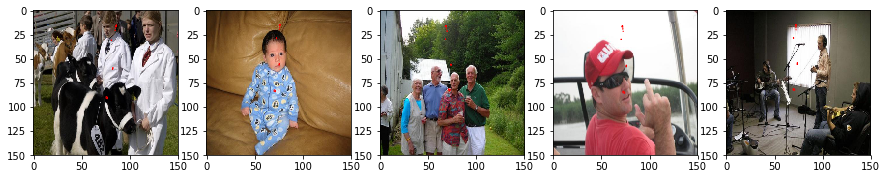

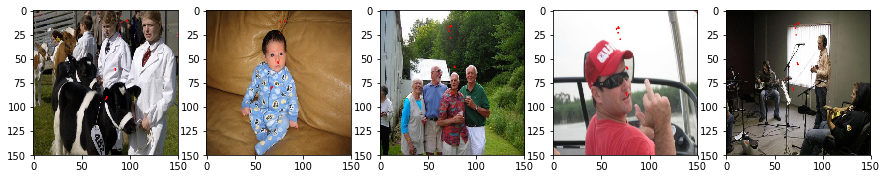

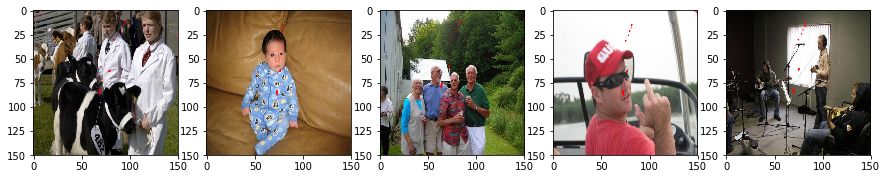

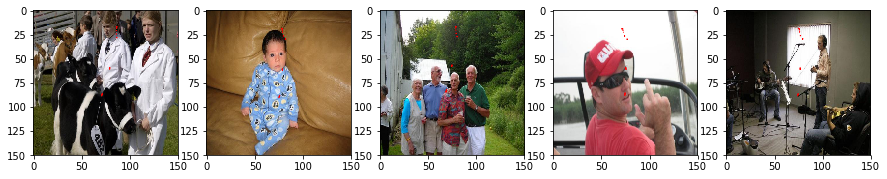

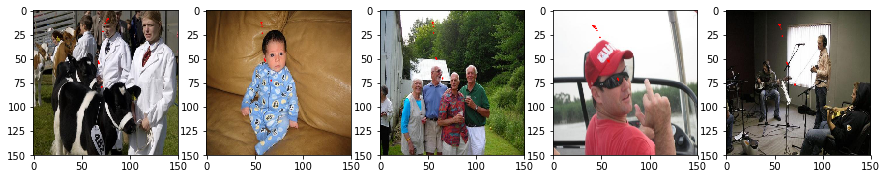

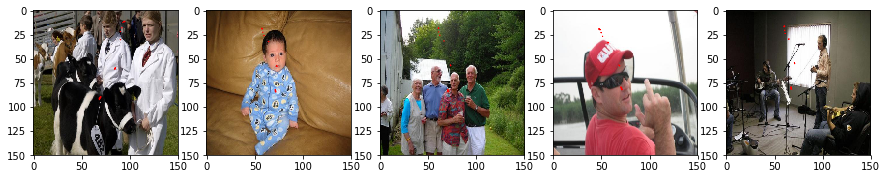

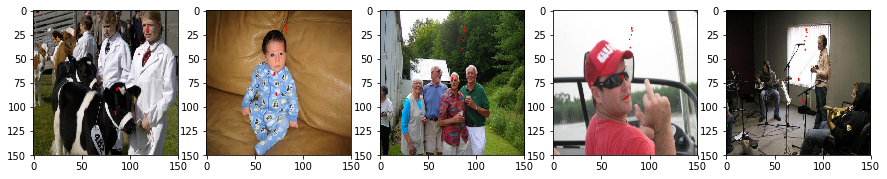

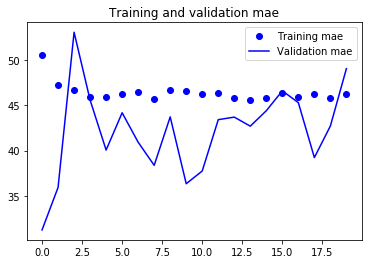

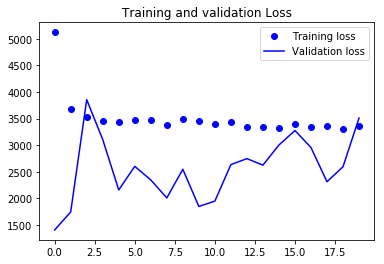

In [23]:
%time history = model.fit_generator(augmentation_generator(x_train, y_train, BATCH_SIZE), \
                                    epochs=NUM_EPOCHS, \
                                    verbose=1, \
                                    steps_per_epoch = len(x_train) / BATCH_SIZE, \
                                    validation_data=([x_val], y_val), \
                                    callbacks=[lambda_callback])

plot_mae(history)

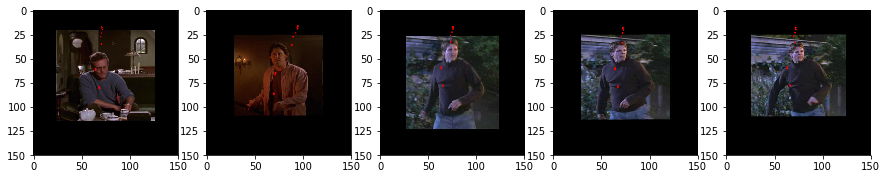

In [24]:
y_predictions = model.predict([x_train[:5]])
display_images_with_annotations(x_train[:5], y_predictions[:5])

### Save model to filesystem

In [25]:
def ensure_model_directory_exists():
    try:
        os.mkdir(SAVED_MODEL_DIR)
    except:
        print('Tried to create "{}" but it already exists'.format(SAVED_MODEL_DIR))

def save_model():
    ensure_model_directory_exists()
    
    evaluate_model_with_test_data = model.evaluate([x_test], y_test)

    accuracy_of_model = evaluate_model_with_test_data[-1]
    timestamp_raw = str(datetime.datetime.now())
    timestamp_without_milliseconds = timestamp_raw.split('.')[0]
    
    model_filename = '{}___{}.h5'.format(timestamp_without_milliseconds, accuracy_of_model)
    model_filepath = os.path.join(SAVED_MODEL_DIR, model_filename)
    
    print('saving file {}'.format(model_filepath))

    model.save(model_filepath)
    return accuracy_of_model
mae = save_model()

Tried to create "../data/models/hands_localization" but it already exists
821/821 [==============================] - 7s 9ms/step
saving file ../data/models/hands_localization/2018-10-21 14:33:20___50.23897324351823.h5


### Call me beep me if you want to reach me

In [26]:
# Send text message when complete (if the environment variable "TEXT_PHONENUMBER" is set)
if 'TEXT_PHONENUMBER' in os.environ:
    text_phonenumber = os.environ['TEXT_PHONENUMBER']
    client = boto3.client('sns')
    client.publish(PhoneNumber=text_phonenumber, Message='Model Finished with mae {}'.format(mae))
    print('text sent')

text sent
